# Model Selection COVID-19 Supervised ML for Unbalanced Data

### Library Imports

In [ ]:
# General Imports
import pandas as pd
import os
import numpy as np
from tabulate import tabulate

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


# Model Evaluation
from sklearn.metrics import accuracy_score, roc_curve, auc, brier_score_loss
from sklearn.metrics import precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

# Graphing 
import matplotlib.pyplot as plt


# dataset balancing
from imblearn.over_sampling import RandomOverSampler

# Explainable ML w/ SHAP
import shap

### Inspect Data

In [2]:
# get file path
fp = '../COVID19 ML/data/covid_subset_final.csv'

## No Oversampling of Minority Class

In [9]:
# use non oversampled data first to make comparisons
xtrain, xtest, ytrain, ytest = train_test_split(df.iloc[:,0:-1], 
                                                df.iloc[:,-1],
                                                train_size=0.8, 
                                                random_state=42)

In [10]:
xtrain.describe()

,AGE,covid_result,sex,race_white,race_black,race_other,ethnic,hypertension,hyperlipidemia,type_2_diabetes_no_complication,...,Heart_rate,Respiratory_rate,Body_height,Body_weight,ACE,ARB,HCQ,STEROID,race,nutrition_deficiency
count,1262.000000,1262.0,1262.000000,1262.000000,1262.000000,1262.00000,1262.000000,1262.000000,1262.000000,1262.000000,...,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,52.568146,1.0,0.394612,0.473059,0.510301,0.01664,0.023772,0.607765,0.427100,0.302694,...,86.984152,18.817750,169.302046,93.703168,0.331220,0.188590,0.022187,0.599842,1.543582,0.433439
std,18.413861,0.0,0.488961,0.499472,0.500092,0.12797,0.152398,0.488442,0.494853,0.459606,...,17.023464,4.708647,11.735051,26.792627,0.470839,0.391337,0.147350,0.490124,0.530664,0.495746
min,19.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,62.999610,27.215520,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,38.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,75.000000,16.000000,162.559900,74.842680,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,55.000000,1.0,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,...,85.000000,18.000000,167.639900,90.718400,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
75%,66.000000,1.0,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,...,98.000000,20.000000,177.800000,108.635200,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000
max,99.000000,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,175.000000,50.000000,200.660000,244.939600,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000


In [11]:
ytrain.value_counts().reset_index()

,index,discharged_home
0,1,1083
1,0,179


In [12]:
# data used for cross validation proposed by reviewer.
x = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [13]:

classifiers = [
    LogisticRegression(solver='liblinear'),
    KNeighborsClassifier(),       
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    SVC(probability=True, kernel='linear')
]
param_grids = {
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7]},
    'DecisionTreeClassifier': {'max_depth': [None, 10, 20]},
    'RandomForestClassifier': {'n_estimators': [100, 200, 300]},
    'SVC': {'C': [0.1, 1, 10]},
}

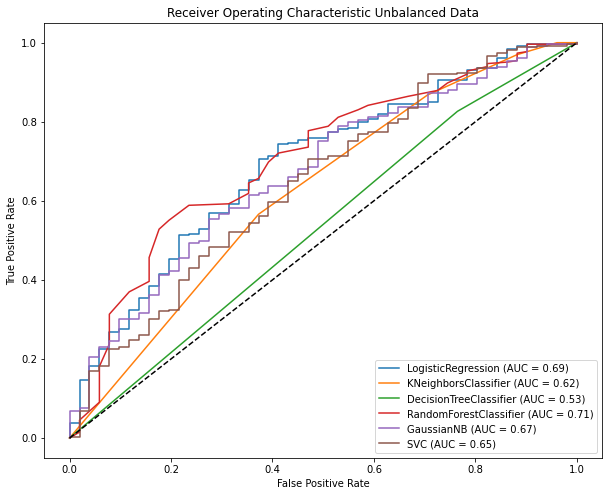

In [16]:
# number of folds for cross-validation
cv = 5  
plt.figure(figsize=(10, 8))

for clf in classifiers:
    scores = cross_val_score(clf, xtrain, ytrain, cv=cv, scoring='roc_auc')
    mean_auc = scores.mean()
    std_auc = scores.std()


    clf.fit(xtrain, ytrain)
    y_pred = clf.predict(xtest)
    y_prob = clf.predict_proba(xtest)[:, 1]
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(ytest, y_pred)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Unbalanced Data')
plt.legend(loc="lower right")
plt.savefig('roc_curve_unbalanced.png', dpi=1000, bbox_inches='tight')
plt.show()

### Calibrated AUCROC Graph

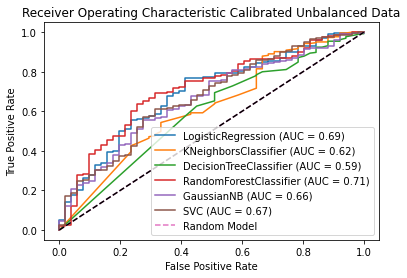

+-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+-----------+
|             |   LogisticRegression |   KNeighborsClassifier |   DecisionTreeClassifier |   RandomForestClassifier |   GaussianNB |       SVC |
|-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+-----------|
| AUC         |            0.693822  |               0.618461 |                 0.594414 |                0.710248  |     0.661709 | 0.67081   |
| Acc         |            0.851266  |               0.838608 |                 0.838608 |                0.835443  |     0.838608 | 0.841772  |
| Precision   |            0.851613  |               0.838608 |                 0.838608 |                0.842444  |     0.838608 | 0.84127   |
| Recall      |            0.996226  |               1        |                 1        |                0.988679  |     1       

In [17]:
# create empty lists to store results
metrics = {
    'AUC': [],
    'Acc': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'Specificity': [],
    'Brier Score': []
}


for clf in classifiers:
    # fit the model
    clf.fit(xtrain, ytrain)
    
    # calibrate the model
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated_clf.fit(xtrain, ytrain)
    
    # make predictions on the test data
    y_pred = calibrated_clf.predict(xtest)
    y_prob = calibrated_clf.predict_proba(xtest)[:, 1]
    
    # calculate metrics
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    brier_score = brier_score_loss(ytest, y_prob)
    tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # organize metrics
    metrics['AUC'].append(roc_auc_score(ytest, y_prob))
    metrics['Acc'].append(accuracy_score(ytest, y_pred))
    metrics['Precision'].append(precision_score(ytest, y_pred))
    metrics['Recall'].append(recall_score(ytest, y_pred))
    metrics['F1'].append(f1_score(ytest, y_pred))
    metrics['Brier Score'].append(brier_score)
    metrics['Specificity'].append(specificity)
    
    # plot the ROC curve
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

# plot the ROC curve for a random model
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Calibrated Unbalanced Data')
plt.legend(loc="lower right")
plt.savefig('calibrated_roc_curve_unbalanced.png', 
            dpi=1000, 
            bbox_inches='tight')
plt.show()

calibrated_unbalanced_metrics_df = pd.DataFrame.from_dict(metrics,
                                                          orient='index',
                                                          columns=[clf.__class__.__name__ for clf in classifiers])

print(tabulate(calibrated_unbalanced_metrics_df, 
               headers='keys', 
               tablefmt='psql'))

## Calbiration Plots

### Unbalanced Calibration Plot

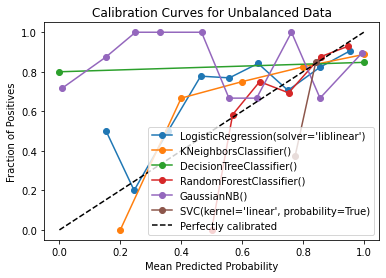

In [15]:
# Unbalanced calibration curve.
# Iterate through each classifier and generate calibration curve
for clf in classifiers:
    clf.fit(xtrain, ytrain)
    prob_pos = clf.predict_proba(xtest)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(ytest, prob_pos, n_bins=10)
    
    # Plot the calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=clf)

# Plot the reference line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

# Set labels and title
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves for Unbalanced Data")
plt.legend()
plt.show()

### Unbalanced Training Through Gridsearch

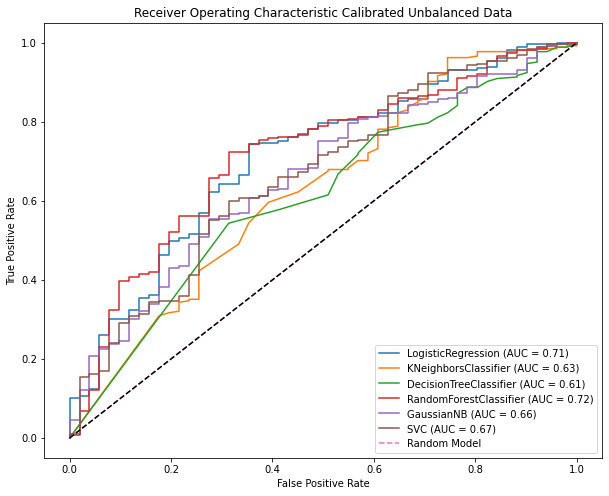

+-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+-----------+
|             |   LogisticRegression |   KNeighborsClassifier |   DecisionTreeClassifier |   RandomForestClassifier |   GaussianNB |       SVC |
|-------------+----------------------+------------------------+--------------------------+--------------------------+--------------+-----------|
| AUC         |            0.707584  |               0.629116 |                 0.612357 |                0.715205  |     0.661709 | 0.666075  |
| Acc         |            0.848101  |               0.838608 |                 0.838608 |                0.835443  |     0.838608 | 0.841772  |
| Precision   |            0.851133  |               0.838608 |                 0.838608 |                0.84466   |     0.838608 | 0.84345   |
| Recall      |            0.992453  |               1        |                 1        |                0.984906  |     1       

In [19]:
# calibrating models based on hyperparameter tuning.

classifiers = [
    LogisticRegression(solver='liblinear', C=0.1),
    KNeighborsClassifier(n_neighbors=7),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=300),
    GaussianNB(),
    SVC(probability=True, kernel='linear',C=10)
]

metrics = {
    'AUC': [],
    'Acc': [],
    'Precision': [],
    'Recall': [],
    'F1': [],
    'Specificity': [],
    'Brier Score': []
}
plt.figure(figsize=(10, 8))

# train the model and generate ROC-AUC Graph
for clf in classifiers:
    # fit the model
    clf.fit(xtrain, ytrain)
    
    # calibrate the model
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
    calibrated_clf.fit(xtrain, ytrain)
    
    # make predictions on the test data
    y_pred = calibrated_clf.predict(xtest)
    y_prob = calibrated_clf.predict_proba(xtest)[:, 1]
    
    # calculate metrics
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)
    acc = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    brier_score = brier_score_loss(ytest, y_prob)
    tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # organize metrics
    metrics['AUC'].append(roc_auc)
    metrics['Acc'].append(acc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1'].append(f1)
    metrics['Brier Score'].append(brier_score)
    metrics['Specificity'].append(specificity)
    
    # plot the ROC curve
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (clf.__class__.__name__, roc_auc))

# plot the ROC curve for a random model
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Calibrated Unbalanced Data')
plt.legend(loc="lower right")
plt.savefig('calibrated_roc_curve_unbalanced.png', 
            dpi=1000, 
            bbox_inches='tight')
plt.show()

calibrated_unbalanced_metrics_df = pd.DataFrame.from_dict(metrics,
                                                          orient='index',
                                                          columns=[clf.__class__.__name__ for clf in classifiers])

print(tabulate(calibrated_unbalanced_metrics_df, 
               headers='keys', 
               tablefmt='psql'))

# Calibrate model and generate calibration graph


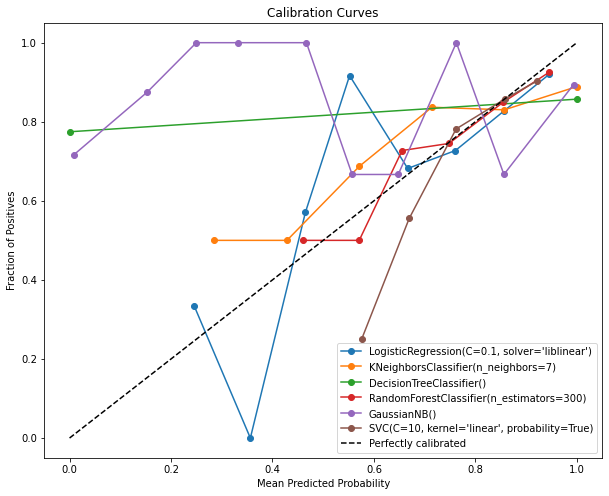

In [18]:
classifiers = [
    LogisticRegression(solver='liblinear', C=0.1),
    KNeighborsClassifier(n_neighbors=7),
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=300),
    GaussianNB(),
    SVC(probability=True, kernel='linear',C=10)
]

plt.figure(figsize=(10, 8))

for clf in classifiers:
    clf.fit(xtrain, ytrain)
    prob_pos = clf.predict_proba(xtest)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(ytest, prob_pos, n_bins=10)
    
    # Plot the calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=clf)

# Plot the reference line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly calibrated')

# Set labels and title
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend()
plt.savefig('calibration_curve.png', dpi=1000, bbox_inches='tight')
plt.show()

## SHAP Analysis

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  0%|          | 0/100 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid

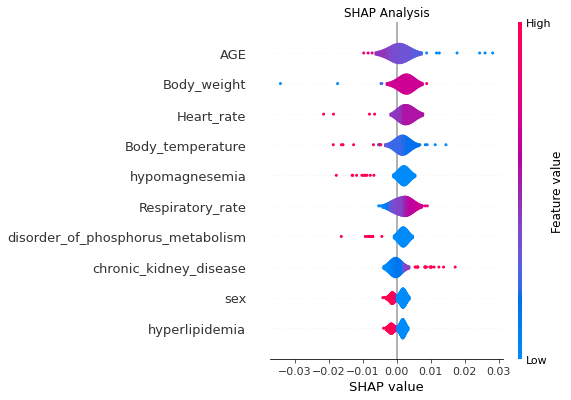

In [20]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=300)
clf.fit(xtrain, ytrain)

# calibrate the model
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
calibrated_clf.fit(xtrain.iloc[:100], ytrain.iloc[:100])

# Create a SHAP explainer object using KernelExplainer
background = shap.sample(xtrain.iloc[:100], 100)
explainer = shap.KernelExplainer(calibrated_clf.predict_proba, background)

# Generate SHAP values for the test data
shap_values = explainer.shap_values(xtest.iloc[:100])

# Create a beeswarm plot
fig, ax = plt.subplots(figsize=(10, 6))
shap.summary_plot(shap_values[1], xtest.iloc[:100], 
                  plot_type='violin', show=False, 
                  sort=True, max_display=10)

plt.title('SHAP Analysis')
ax.set_xlabel('SHAP value')
plt.savefig('shap_analysis_r2.png', dpi=1000, bbox_inches='tight')
plt.show()